<a href="https://colab.research.google.com/github/Risuo/Euler/blob/master/Classification_%26_Regression_Final_Project_Birmingham_Parking_Garage_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apologies for the length of this project! The first part is processing on the dataset (a collection of by-garage occupancy data collected over a number of months in Birmingham, at non-uniform frequency and timing). 

# The second part is a quick visual representation of by-hour average occupancy rates broken down by garage. 

# The third part begins the cleaning of the dataset to be able to be run through our regression & classification analysis. 

### Dataset can be found here: http://archive.ics.uci.edu/ml/datasets/Parking+Birmingham

###

In [0]:
from collections import defaultdict
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [0]:
matplotlib.style.use('ggplot')

In [0]:
def create_full():
  dataset = []
  f = open("/gdrive/My Drive/Birmingham Parking Data/dataset.csv")
  header = f.readline().strip().split(',')
  for line in f:
    line = line.strip('\n').split(',')
    line[1] = int(line[1])
    line[2] = int(line[2])
    line[3] = time.strptime(line[3], '%Y-%m-%d %H:%M:%S')
    line.append(line[2]/line[1])
    dataset.append(line)
  header.append('Occupancy%')
  return dataset, header

First bit of cleaning needing to be done was to remove a newline (\n) text content from the fourth entry of every line. 

We're also formatting the capacity & occupancy entries as integers, and modifying the time entry into a timeStructure so we can manipulate it later. 

In [0]:
dataset, header = create_full()

We're going to be performing regression and classification analysis on this dataset.  

The regression analysis will attempt to predict whether or not the parking garage is filling up or emptying out at a given time (or perhaps at 50% or greater occupancy, not sure which I'd prefer at this point).

The classification analysis will attempt to predict how many available spots there are at a given time. 

In [229]:
 header, dataset[0], dataset[1], dataset[2]

(['SystemCodeNumber', 'Capacity', 'Occupancy', 'LastUpdated', 'Occupancy%'],
 ['BHMBCCMKT01',
  577,
  61,
  time.struct_time(tm_year=2016, tm_mon=10, tm_mday=4, tm_hour=7, tm_min=59, tm_sec=42, tm_wday=1, tm_yday=278, tm_isdst=-1),
  0.10571923743500866],
 ['BHMBCCMKT01',
  577,
  64,
  time.struct_time(tm_year=2016, tm_mon=10, tm_mday=4, tm_hour=8, tm_min=25, tm_sec=42, tm_wday=1, tm_yday=278, tm_isdst=-1),
  0.11091854419410745],
 ['BHMBCCMKT01',
  577,
  80,
  time.struct_time(tm_year=2016, tm_mon=10, tm_mday=4, tm_hour=8, tm_min=59, tm_sec=42, tm_wday=1, tm_yday=278, tm_isdst=-1),
  0.1386481802426343])

We're going to do a little visual representation of the dataset here. We'll be showing the occupancy rates of the various parking garages over a span of time. There are 30 different parking garages in the dataset, and while we'll be eliminating the by-garage difference on the data we work with for the regression/classification, at this point separating them into 30 different buckets will allow us to visualize how their occupancy goes. 

In [230]:
garageList = ['BHMBCCMKT01','BHMBCCPST01','BHMBCCSNH01','BHMBCCTHL01','BHMBRCBRG01','BHMBRCBRG02','BHMBRCBRG03',
           'BHMBRTARC01','BHMEURBRD01','BHMEURBRD02','BHMMBMMBX01','BHMNCPHST01','BHMNCPLDH01','BHMNCPNHS01',
           'BHMNCPNST01','BHMNCPPLS01','BHMNCPRAN01','Broad Street','Bull Ring','NIA Car Parks','NIA North',
           'NIA South','Others-CCCPS105a','Others-CCCPS119a','Others-CCCPS133','Others-CCCPS135a','Others-CCCPS202',
           'Others-CCCPS8','Others-CCCPS98','Shopping']

garage_dict = defaultdict(list)

for g in garageList:
  for d in dataset:
    if d[0] == g:
      times = [d[3].tm_wday, d[3].tm_hour, d[3].tm_min] #extracting the week-day, hour, and minute info
      times.append(d[4]) # extracting the occupancy % field
      garage_dict[g].append(times) # appending to the by-garage dictionary entry
      
for a in garage_dict:
  print(a, len(garage_dict[a]))
  


BHMBCCMKT01 1312
BHMBCCPST01 1276
BHMBCCSNH01 1294
BHMBCCTHL01 1312
BHMBRCBRG01 1186
BHMBRCBRG02 1186
BHMBRCBRG03 1186
BHMBRTARC01 88
BHMEURBRD01 1312
BHMEURBRD02 1276
BHMMBMMBX01 1312
BHMNCPHST01 1312
BHMNCPLDH01 1292
BHMNCPNHS01 1038
BHMNCPNST01 1312
BHMNCPPLS01 1291
BHMNCPRAN01 1186
Broad Street 1312
Bull Ring 1186
NIA Car Parks 1204
NIA North 162
NIA South 1204
Others-CCCPS105a 1312
Others-CCCPS119a 1312
Others-CCCPS133 1294
Others-CCCPS135a 1312
Others-CCCPS202 1312
Others-CCCPS8 1312
Others-CCCPS98 1312
Shopping 1312


In [231]:
print(garage_dict['BHMMBMMBX01'][:5])
print(garage_dict['BHMNCPPLS01'][:5])

[[1, 7, 59, 0.38427947598253276], [1, 8, 25, 0.4395924308588064], [1, 8, 59, 0.5036390101892285], [1, 9, 32, 0.6026200873362445], [1, 9, 59, 0.7059679767103348]]
[[1, 7, 46, 0.1688888888888889], [1, 7, 46, 0.1688888888888889], [1, 8, 25, 0.18222222222222223], [1, 8, 59, 0.18888888888888888], [1, 9, 25, 0.18666666666666668]]


## We'll be creating a new entry to allow us to visualize the average occupancy of each garage by hour below. 

In [0]:
def create_hour_averages(garageList, garage_dict):
  garageDictOut = defaultdict(list)
  for garage in garageList:
    hourAverages = {}
    garage_hour_averages = defaultdict(list)
    for a in garage_dict[garage]:
      garage_hour_averages[a[1]].append(a[3])
    for b in garage_hour_averages:
      hourAverages[b] = (sum(garage_hour_averages[b]) / len(garage_hour_averages[b]))*100
    garageDictOut[garage].append(hourAverages) 
  return garageDictOut



In [233]:
hourlyAvgAllGarages = create_hour_averages(garageList, garage_dict)

hourlyAvgAllGarages['BHMMBMMBX01']

[{7: 44.22956955708047,
  8: 46.14461623195246,
  9: 56.70994402274262,
  10: 66.36109304510308,
  11: 73.10821319614762,
  12: 78.13826188572483,
  13: 81.01681605761127,
  14: 82.34904381870201,
  15: 76.96832806304272,
  16: 69.76986397630874}]

In [0]:
def build_barGraphs(dataset, n_graphs):
  dataset = dataset
  n_graphs = n_graphs
  
  fig = plt.figure(figsize=(4*(n_graphs),4*(n_graphs)))
  gs = gridspec.GridSpec(nrows=n_graphs, ncols=n_graphs)
  
  xCoord = 0
  yCoord = 0
  
  for entry in hourlyAvgAllGarages:
    for garage in hourlyAvgAllGarages[entry]:
      xAxis = []
      yAxis = []
      for k,v in garage.items():
        xAxis.append(k)
        yAxis.append(v)
      b = fig.add_subplot(gs[xCoord,yCoord])
      b.bar(xAxis, yAxis)
      b.set_ylim([0,100])
      b.set_title(str(entry))
      
      if xCoord < n_graphs**.5-1:
        xCoord += 1
      else:
        xCoord = 0
        yCoord += 1
        
  plt.tight_layout()
  plt.show()
      
  

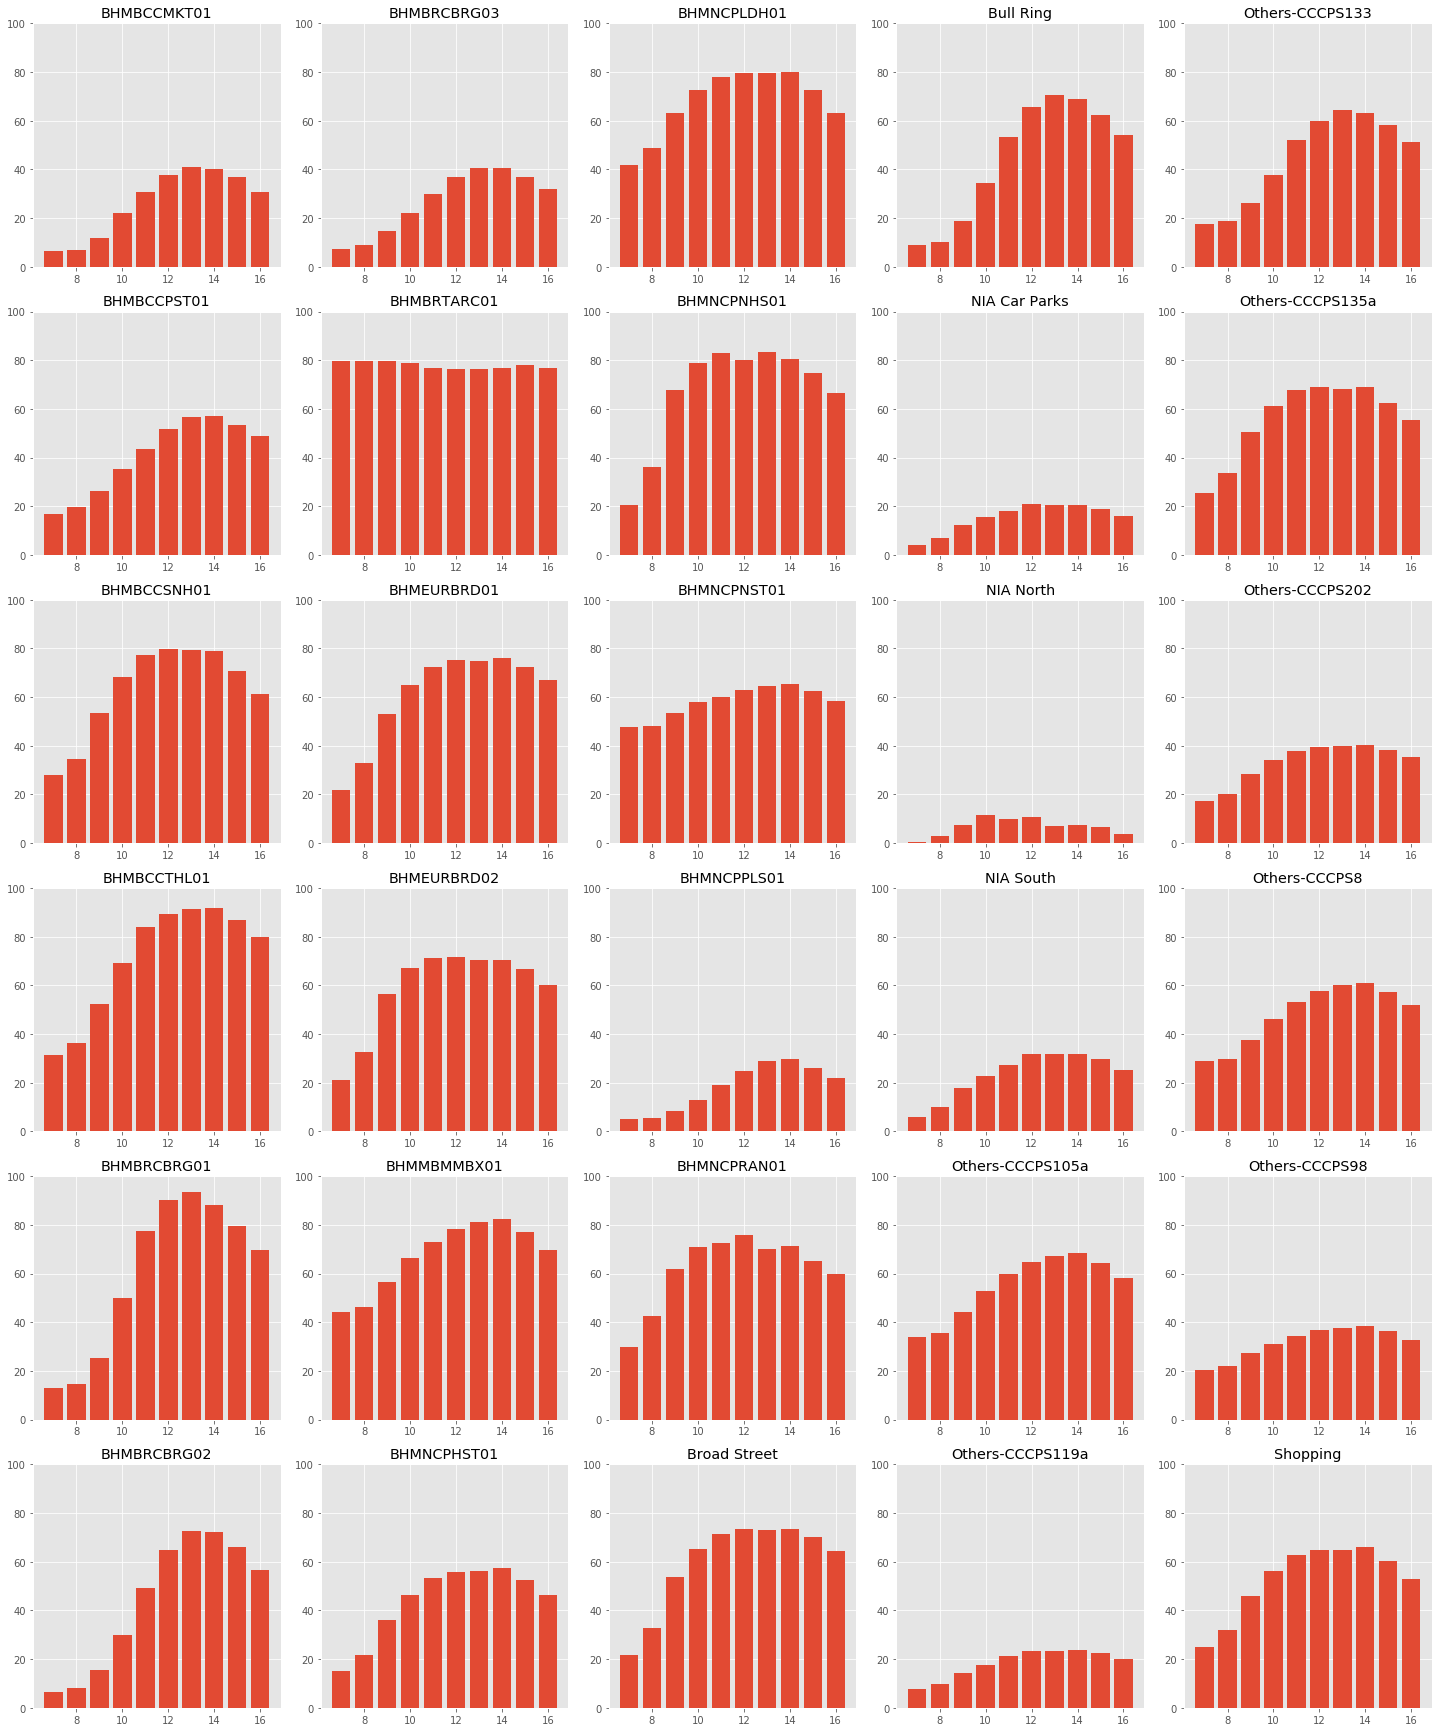

In [235]:
build_barGraphs(hourlyAvgAllGarages, len(hourlyAvgAllGarages))

As might have been expected, with a few exceptions, the garages tend to start emptier, and fill up through the day, with a peak around Noon or shortly thereafter. 

With that taken care of, let's turn to the task at hand. Regression and classification. 

As a reminder, our classification analysis will attempt to predict whether or not there are more or less than 50% of all parking spots remaining available. 

The regression analysis will attempt to predict how many available spots there are (as a percentage of all spots) at a given time.

Our first step will be to normalize the data from each of the multiple garages, to create a total number of spots available/taken among ALL garages, at the measured point in time.

The first obstacle will be the inconsistencies present in various effectively 'simultaneous' time measurements (variations within the seconds or few minutes timing measurement between garages). The following code blocks deals with that problem.

In [0]:
def create_full_two():
  dataset = []
  f = open("/gdrive/My Drive/Birmingham Parking Data/dataset.csv")
  header = f.readline().strip().split(',')
  hour_entered = False
  for line in f:
    line = line.strip('\n').split(',')
    line[1] = int(line[1])
    line[2] = int(line[2])
    line[3] = time.strptime(line[3], '%Y-%m-%d %H:%M:%S')
    line.append(line[2]/line[1]) #Occupancy%
    line.append([line[3].tm_yday, line[3].tm_wday, line[3].tm_hour, line[3].tm_min]) #Weekday & Hour (24H format)
        
    try: #This is a look-back method that identifies the previous hour entry, compares it with the current hour entry, and if the same, adds an index, which will 
         #be utilized in the find_total_occupancy method so as to separate out the hour counts by multiple readings/hour, where applicable.
         #This is required, rather than just splitting by some set number of minutes, because the intervals between measurements are unfixed, and therefore
         #has entries with unpredictable frequency (multiple readings within the same span of a few minutes).
      prev_hour_entered = dataset[-1][4][:3] #Identifies the most recently entered entry's yDay, wDay, & hour data 
      if prev_hour_entered == line[5][:3]:   #Determines if the yDay, wDay & hour are the same, and if so  
        line.append(dataset[-1][5] +1)       #Appends the index value to the time entry data
      else:
        line.append(1)
    except:
      line.append(1)
      
      
    line.pop(3) #Removes the full strptime formatted data
    line.append((line[1]-line[2])) #Remaining Spots
    #line.pop(0) #Removes the per-garage labelling
    
    
    dataset.append(line)
  

  
  header.append('Occupancy%')
  header.pop(3)
  header.append('Weekday,Hour')
  header.append('Remaining')
  
  
  
  
  return dataset, header

In [0]:
dataset2, header2 = create_full_two()

In [238]:
header2,dataset2[:10],dataset2[-10:]

(['SystemCodeNumber',
  'Capacity',
  'Occupancy',
  'Occupancy%',
  'Weekday,Hour',
  'Remaining'],
 [['BHMBCCMKT01', 577, 61, 0.10571923743500866, [278, 1, 7, 59], 1, 516],
  ['BHMBCCMKT01', 577, 64, 0.11091854419410745, [278, 1, 8, 25], 1, 513],
  ['BHMBCCMKT01', 577, 80, 0.1386481802426343, [278, 1, 8, 59], 2, 497],
  ['BHMBCCMKT01', 577, 107, 0.1854419410745234, [278, 1, 9, 32], 1, 470],
  ['BHMBCCMKT01', 577, 150, 0.25996533795493937, [278, 1, 9, 59], 2, 427],
  ['BHMBCCMKT01', 577, 177, 0.30675909878682844, [278, 1, 10, 26], 1, 400],
  ['BHMBCCMKT01', 577, 219, 0.37954939341421146, [278, 1, 10, 59], 2, 358],
  ['BHMBCCMKT01', 577, 247, 0.42807625649913345, [278, 1, 11, 25], 1, 330],
  ['BHMBCCMKT01', 577, 259, 0.4488734835355286, [278, 1, 11, 59], 2, 318],
  ['BHMBCCMKT01', 577, 266, 0.4610051993067591, [278, 1, 12, 29], 1, 311]],
 [['Shopping', 1920, 1424, 0.7416666666666667, [354, 0, 12, 3], 1, 496],
  ['Shopping', 1920, 1475, 0.7682291666666666, [354, 0, 12, 30], 2, 445],
  [

In [0]:
# Here we're going to write a method to find the total occupancy per yDay data within the dataset

def find_total_occupancy(dataset2):
  
  yData = defaultdict(list)
  
  for line in dataset2:
    if line[4][-1] <= 20:
      yData[line[4][0],line[4][2],line[5],20].append((line[2],line[1]))
    elif 20 < line[4][-1] <= 40:
      yData[line[4][0],line[4][2],line[5],40].append((line[2],line[1]))
    else:
      yData[line[4][0],line[4][2],line[5],60].append((line[2],line[1]))
  for minute_Split in yData:
    occSum = 0
    availSum = 0
    for item in yData[minute_Split]:
      occSum += item[0]
      availSum += item[1]
    yData[minute_Split] = (occSum, availSum, len(yData[minute_Split]))

  return yData
  

In [0]:
# Here we're going to extract the total number of available parking spots
def find_total_spots(dataset2,garageList):
  
  table = defaultdict(list)
  totalSpots = 0

  for line in dataset2:
    for garage in garageList:
      if line[0] == garage:
        table[garage] = line[1]
    
  for a in table:
    totalSpots += table[a]

  return totalSpots

In [0]:
def create_table(dataset2, garageList):
  
  totalSpots = find_total_spots(dataset2,garageList)
  
  occupancyData = find_total_occupancy(dataset2)

  #print(dataset3)
  
  table = []

  for a in occupancyData:
    table.append([a,occupancyData[a]])

  print("(tm_yday, tm_wday, time-reading-index/hr, 0-20/21-40/41-60)", "(Total occupied spots", "garage instances with entry)")


  return table



In [0]:
def find_Limits(dataset):
  maxOccupied = 0
  maxGarageInstance = 0
  maxTimeIndex = 0

  minOccupied = 10000
  minGarageInstance = 100
  minTimeIndex = 100


  for c in table:
    if c[1][0] > maxOccupied:
      maxOccupied = c[1][0]
    if c[1][0] < minOccupied:
      minOccupied = c[1][0]
    if c[1][2] > maxGarageInstance:
      maxGarageInstance = c[1][1]
    if c[1][2] < minGarageInstance:
      minGarageInstance = c[1][1]
    if c[0][2] > maxTimeIndex:
      maxTimeIndex = c[0][2]
    if c[0][2] < minTimeIndex:
      minTimeIndex = c[0][2]



  print('\nMaximum Occupied State of all Garages within a 20 minute spread of any hour:', maxOccupied, 
        '\nMaximum number of Spots included in the count:', maxGarageInstance, 
        '\nMaximum number of discrete readings/hour in any garage:', maxTimeIndex, '\n',
        '\nMinimum Occupied State of all Garages within a 20 minute spread of any hour:', minOccupied,
        '\nMinimum number of Spots included in the count:', minGarageInstance,
        '\nMinimum number of discrete readings/hour in any garage:', minTimeIndex, '\n')

In [0]:
def head_Foot(table, n):
  print('\nFirst and Last', n, 'readings\n')

  for a in table[:n]:
    print(a)
  for b in table[-n:]:
    print(b)

In [244]:
table = create_table(dataset2, garageList)

print('\nPre-cleaning full table max/mins:')
head_Foot(table, 5)
find_Limits(table)
print("Total number of time readings:",len(table))

table = [a for a in table if a[1][2] > 20]

print('\nPost-cleaning full table max/mins:')
head_Foot(table, 5)
find_Limits(table)
print("Total number of time readings:",len(table))

(tm_yday, tm_wday, time-reading-index/hr, 0-20/21-40/41-60) (Total occupied spots garage instances with entry)

Pre-cleaning full table max/mins:

First and Last 5 readings

[(278, 7, 1, 60), (7852, 38980, 28)]
[(278, 8, 1, 40), (9648, 38980, 28)]
[(278, 8, 2, 60), (12296, 38980, 28)]
[(278, 9, 1, 40), (14905, 38980, 28)]
[(278, 9, 2, 60), (17109, 38980, 28)]
[(353, 13, 2, 60), (80, 600, 1)]
[(353, 15, 2, 60), (64, 600, 1)]
[(353, 16, 1, 40), (61, 600, 1)]
[(313, 13, 3, 60), (677, 690, 1)]
[(313, 14, 1, 40), (647, 690, 1)]

Maximum Occupied State of all Garages within a 20 minute spread of any hour: 28183 
Maximum number of Spots included in the count: 38980 
Maximum number of discrete readings/hour in any garage: 6 
 
Minimum Occupied State of all Garages within a 20 minute spread of any hour: 4 
Minimum number of Spots included in the count: 690 
Minimum number of discrete readings/hour in any garage: 1 

Total number of time readings: 1782

Post-cleaning full table max/mins:

First 

In [0]:
for a in table:
  a.append(a[1][0]/a[1][1] > .5)

# Quick Catchup:

## At this point we've successfully curated our dataset to have the following qualities: a) every entry represents a unique collection of garage-occupancy readings associated by: Day of the year, Hour of the day, Reading of the day (1st, 2nd, 3rd) and whether it is in the first, second or third portion of the hour (0-20 minutes, 21-40 minutes, 41-60 minutes).

## We have also shown that the number of garages and maximum occupancy never passes over the known maximum number of spots or garages included in the dataset. 

## We have also eliminated out any time-instance data where the number of garages showing an entry for that particular 20 minute spread was fewer than 26 garages (outliers)

## We are now ready to perform some regression and classification analysis!

### We will be largely reusing the code from the lectures when it comes to the regression & classification analysis itself. With minor tweaks here and there, but the implementation is generally speaking the same, and as noted in the description of the project "The goal is to understand how to transform data to be suitable for data-driven predictive tasks (I.e., feature extraction) rather than to learn the machine learning concepts per se."  All the same we do improve upon the first attempts below by implementing one-hot notation of our time data (parameters) to obtain fairly significant improvements in the accuracy of both the regression and classification algorithms.  

In [246]:
head_Foot(table, 5)


First and Last 5 readings

[(278, 7, 1, 60), (7852, 38980, 28), False]
[(278, 8, 1, 40), (9648, 38980, 28), False]
[(278, 8, 2, 60), (12296, 38980, 28), False]
[(278, 9, 1, 40), (14905, 38980, 28), False]
[(278, 9, 2, 60), (17109, 38980, 28), False]
[(354, 14, 2, 40), (28183, 36924, 26), True]
[(354, 15, 1, 20), (27583, 36924, 26), True]
[(354, 15, 2, 40), (26560, 36924, 26), True]
[(354, 16, 1, 20), (24667, 36924, 26), True]
[(354, 16, 2, 40), (22879, 36924, 26), True]


In [0]:
import tensorflow as tf
import random

In [0]:
tableRandom = table
random.shuffle(tableRandom)

In [249]:
head_Foot(tableRandom, 5)


First and Last 5 readings

[(327, 12, 1, 20), (21965, 38480, 27), True]
[(334, 9, 1, 20), (12658, 38530, 27), False]
[(349, 15, 2, 60), (21661, 39476, 29), True]
[(285, 11, 1, 40), (17814, 32874, 24), True]
[(288, 8, 1, 20), (8379, 38980, 28), False]
[(315, 13, 2, 40), (22917, 39010, 28), True]
[(325, 8, 2, 40), (4433, 35031, 23), False]
[(354, 15, 1, 20), (27583, 36924, 26), True]
[(346, 10, 2, 60), (13137, 36424, 25), False]
[(284, 8, 1, 20), (6505, 32424, 23), False]


# First Up: Regression analysis to predict occupancy (as a percentage of total spots)!

In [0]:
def feature(datum):
  f = datum[0] # saves me some typing
  feat = [1, float(f[0]), float(f[1]), float(f[3])] # day of the year, hour of the day, and minute-bracket
  return feat

In [0]:
X = [feature(d) for d in tableRandom] # gives us a feature table 
y = [float(d[1][0]/d[1][1]*1000) for d in tableRandom] # gives us the value we want to predict

In [308]:
tableRandom[0],X[0],y[0],len(X),len(y) # showing us where we're at with respect to formatting/selecting/etc

([(327, 12, 1, 20), (21965, 38480, 27), True],
 [1, 327.0, 12.0, 20.0],
 570.8160083160083,
 1305,
 1305)

In [309]:
N = len(X) #saves space below

X_test = X[:N//2]   #as per the lecture, we've created a randomly shuffled collection of feature & values
X_train = X[N//2:]

y_test = y[:N//2]   #and this is what we'll test the model on to see how accurately it does. 
y_train = y[N//2:]

len(X_test), len(X_train)


(652, 653)

In [0]:
y_train = tf.constant(y_train, shape=[len(y_train),1])

In [0]:
K = len(X_train[0]) # saving space below, when working with our thetas, if we modify the number of parameters above, this will automatically update the tensorflow vector shape

In [0]:
def MSE(X, y, theta):
  return tf.reduce_mean((tf.matmul(X,theta) - y)**2) #perform dot-product multiplication of X and theta, then subtract from that y (the error) then square it, then reduce to the mean to return
                                                     #the mean-squared-error, or MSE

In [0]:
theta = tf.Variable(tf.constant([0.0]*K, shape=[K,1])) #initialize the theta values as VARIABLES, whose initial value is 0.0, and do so for all K (the number of parameters) and then 
                                                       #define the tensorflow shape as being that of a K length column of width 1

In [0]:
optimizer = tf.train.AdamOptimizer(0.05) # initializing the optimizer, Stochastic gradient descent, learning rate set to be .05

In [0]:
objective = MSE(X_train, y_train, theta) #define the objective, what we want to optimize, as that of the MSE result when performed on our training sets of X, Y, and theta
                                         #we are mostly defining theta as the variable (see above) that can be modified in order to affect the MSE value

In [0]:
train = optimizer.minimize(objective)

In [0]:
init = tf.global_variables_initializer()

In [0]:
sess = tf.Session()
sess.run(init)

In [319]:
for iteration in range(50000):
  cvalues = sess.run([train, objective])
  if iteration%5000 == 0:
    print('objective = ' + str(cvalues[1]))  # this is processing the gradient descent of MSE 5000 times, and prints out the MSE each time

objective = 233608.38
objective = 11406.552
objective = 10908.16
objective = 10684.353
objective = 10659.96
objective = 10659.422
objective = 10659.414
objective = 10659.413
objective = 10659.415
objective = 10659.414


In [0]:
def testThetas(thetasEval, testValues):
  thetasEval = [float(a) for a in thetasEval]
  #print(thetasEval, 'thetasEval')
  #print(testValues, 'testValues')
  outTable = []
  for q in testValues:
    test = [a*b for a,b in zip(thetasEval,q)]
    outTable.append(sum(test))
  return outTable


In [321]:
with sess.as_default():
  print('MSE is =', MSE(X_train,y_train,theta).eval())
  print('thetas are:\n', theta.eval())
  print('The thetas, which are multiplied by 1, day of the year, hour of the day, and minute-bracket, respectively')
  
  thetasEval = theta.eval()
  testValues = X_test
  
  testResults = testThetas(thetasEval,testValues)
  
  print(testResults[:5])
  print(y_test[:5])
  
  accuracy = zip(testResults,y_test)
  
  error = [((((a-b)**2)**.5)/b)*100 for a,b in accuracy]
  
  print(error[:5])
  
  avg_Error = sum(error)/len(error)
  
  print(avg_Error, 'as a % of the y_test value')

MSE is = 10667.427
thetas are:
 [[-456.65088  ]
 [   1.4939015]
 [  35.030247 ]
 [   0.8204493]]
The thetas, which are multiplied by 1, day of the year, hour of the day, and minute-bracket, respectively
[468.62685537338257, 373.9934256076813, 639.4014000892639, 387.26173186302185, 270.2437102794647]
[570.8160083160083, 328.52322865299766, 548.7131421623264, 541.8872056944698, 214.95638789122626]
[17.902292762268324, 13.840785974592826, 16.527444115801597, 28.534623480043898, 25.720250945143043]
25.374496338920334 as a % of the y_test value


## And here we have our first set of results. We've treated (naively) the time-value parameters as numerical, rather than categorical, values. We will fix this down below. 

## Time to perform our classification analysis, i.e., are the parking garages more than 50% full or not. We'll be using sklearn as per the lectures.

In [0]:
from sklearn import linear_model
import random

In [0]:
X_classification = [feature(d) for d in tableRandom] # we can reuse the naieve feature table from above for the features here again
y_classification = [value[-1] for value in tableRandom]

In [0]:
N = len(X_classification)

X_train_1 = X_classification[:N//2]

X_test_1 = X_classification[N//2:]

y_train_1 = y_classification[:N//2]

y_test_1 = y_classification[N//2:]

In [325]:
len(X_classification), len(X_train_1), len(X_test_1)

(1305, 652, 653)

In [326]:
len(y_classification), len(y_train_1), len(y_test_1)

(1305, 652, 653)

In [0]:
model = linear_model.LogisticRegression()

In [328]:
model.fit(X_train_1, y_train_1)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [329]:
predictionsTrain = model.predict(X_train_1)
predictionsTest  = model.predict(X_test_1)


correctPredictionsTrain = predictionsTrain == y_train_1 # this compares the elements from predictions, an array, against y, our collection of values from which it learned
correctPredictionsTest  = predictionsTest  == y_test_1

print('This is the accuracy of our model on our training dataset:',sum(correctPredictionsTrain) / len(correctPredictionsTrain)*100, '%')

# taking the sum of a boolean array treats all 'True' items as a 1, and 'False' as 0

print('This is the accuracy of our model on our testing dataset:',sum(correctPredictionsTest)  / len(correctPredictionsTest)*100, '%')

This is the accuracy of our model on our training dataset: 73.46625766871165 %
This is the accuracy of our model on our testing dataset: 71.97549770290965 %


## Perhaps unexpectedly, our model is not PARTICULARLY accurate given the fact that it, again, is treating the time-value data as continuous parameters, rather than categorical ones. We will refresh this as well below. 

In [330]:
head_Foot(tableRandom, 5) #so we don't have to keep scrolling, and as a reminder of the cleaned dataset we're working with


First and Last 5 readings

[(327, 12, 1, 20), (21965, 38480, 27), True]
[(334, 9, 1, 20), (12658, 38530, 27), False]
[(349, 15, 2, 60), (21661, 39476, 29), True]
[(285, 11, 1, 40), (17814, 32874, 24), True]
[(288, 8, 1, 20), (8379, 38980, 28), False]
[(315, 13, 2, 40), (22917, 39010, 28), True]
[(325, 8, 2, 40), (4433, 35031, 23), False]
[(354, 15, 1, 20), (27583, 36924, 26), True]
[(346, 10, 2, 60), (13137, 36424, 25), False]
[(284, 8, 1, 20), (6505, 32424, 23), False]


# We will be converting our time-data into one-hot notation now. 


### The following code was based off of this blog post on creating one-hot notation : https://jovianlin.io/keras-one-hot-encode-decode-sequence-data/

In [0]:
import numpy as np
from keras.utils import to_categorical

In [0]:
data = np.array([a[0] for a in tableRandom])

In [333]:
print(data)

[[327  12   1  20]
 [334   9   1  20]
 [349  15   2  60]
 ...
 [354  15   1  20]
 [346  10   2  60]
 [284   8   1  20]]


In [0]:
def encode(data):
  print('Shape of data (BEFORE encode): %s' % str(data.shape))
  encoded = to_categorical(data)
  print('Shape of data (AFTER encode): %s' %str(encoded.shape))
  return encoded

In [335]:
encoded_data = encode(data)

print(encoded_data[0].shape)

Shape of data (BEFORE encode): (1305, 4)
Shape of data (AFTER encode): (1305, 4, 355)
(4, 355)


## What have we done? We have transformed our time-data parameters (Day of the year, Hour of the day, Reading of the hour, Bracket of 1st/2nd/3rd 20 minute split of the hour) into a 4 entry, 355/entry length collection of one-hot notation arrays, each one representing the combination of the four parameters mentioned above. So let's change a few things from the above code and see if we can't get a better prediction. 

In [0]:
def feature(datum):
  q = [float(a) for a in datum[0]]
  r = [float(a) for a in datum[1]]
  s = [float(a) for a in datum[2]]
  t = [float(a) for a in datum[3]]
  feat = [1]+q+r+s+t
  return feat

In [0]:
X = [feature(d) for d in encoded_data]

In [338]:
len(X[0]) # we now have over 1400 parameters, vs. the 4 we had before, that the program will be tweaking (in reality, most of them are just zeros given the disparity between the number of days and the number of hours
           # or even more dramatically, the difference between day and the number of readings/hour)

1421

In [0]:
y = [float(d[1][0]/d[1][1]*1000) for d in tableRandom] # we can keep this the same, since it our target, i.e., what we're attempting to predict.

In [340]:
N = len(X) #saves space below

X_test = X[:N//2]   #as per the lecture, we've created a randomly shuffled collection of feature & values
X_train = X[N//2:]

y_test = y[:N//2]   #and this is what we'll test the model on to see how accurately it does. 
y_train = y[N//2:]

len(X_test), len(X_train)

(652, 653)

In [0]:
y_train = tf.constant(y_train, shape=[len(y_train),1])

In [0]:
K = len(X_train[0])

In [0]:
def MSE(X, y, theta):
  return tf.reduce_mean((tf.matmul(X,theta) - y)**2)

In [0]:
theta = tf.Variable(tf.constant([0.0]*K, shape=[K,1]))

In [0]:
optimizer = tf.train.AdamOptimizer(0.05)

In [0]:
objective = MSE(X_train, y_train, theta)

In [0]:
train = optimizer.minimize(objective)

In [0]:
init = tf.global_variables_initializer()

In [0]:
sess = tf.Session()
sess.run(init)

In [350]:
for iteration in range(20000):
  cvalues = sess.run([train, objective])
  if iteration%2000 == 0:
    print('objective = ' + str(cvalues[1]))

objective = 233608.38
objective = 24588.773
objective = 4444.5522
objective = 1995.1124
objective = 1818.5547
objective = 1816.7739
objective = 1816.7695
objective = 1816.7693
objective = 1816.7698
objective = 1816.7698


In [0]:
def testThetas(thetasEval, testValues):
  thetasEval = [float(a) for a in thetasEval]
  #print(thetasEval, 'thetasEval')
  #print(testValues, 'testValues')
  outTable = []
  for q in testValues:
    test = [a*b for a,b in zip(thetasEval,q)]
    outTable.append(sum(test))
  return outTable

In [354]:
with sess.as_default():
  print('MSE is =', MSE(X_train,y_train,theta).eval())
  
  
  thetasEval = theta.eval()
  testValues = X_test
  
  testResults = testThetas(thetasEval,testValues)
  
  print(testResults[:5])
  print(y_test[:5])
  
  accuracy = zip(testResults,y_test)
  
  error = [((((a-b)**2)**.5)/b)*100 for a,b in accuracy]
  
  print(error[:5])
  
  avg_Error = sum(error)/len(error)
  
  print(avg_Error, 'as a % of the y_test value')

MSE is = 1816.7698
[514.3497543334961, 355.24925994873047, 603.0153656005859, 514.7384796142578, 211.637451171875]
[570.8160083160083, 328.52322865299766, 548.7131421623264, 541.8872056944698, 214.95638789122626]
[9.892198740027629, 8.135202921666814, 9.896286286176686, 5.010032677449696, 1.5440046941199665]
10.988861784531165 as a % of the y_test value


# Success! We've dropped our regression analysis accuracy down to only a 10% error, from the 24% error above!

# Now we'll try the same thing for our classification analysis (At or below 50% occupancy prediction.)

In [0]:
X_classification = [feature(d) for d in encoded_data] # we can reuse the naieve feature table from above for the features here again
y_classification = [value[-1] for value in tableRandom]

In [0]:
N = len(X_classification)

X_train_1 = X_classification[:N//2]

X_test_1 = X_classification[N//2:]

y_train_1 = y_classification[:N//2]

y_test_1 = y_classification[N//2:]

In [357]:
len(X_classification), len(X_train_1), len(X_test_1)

(1305, 652, 653)

In [358]:
len(y_classification), len(y_train_1), len(y_test_1)

(1305, 652, 653)

In [0]:
model = linear_model.LogisticRegression()

In [360]:
model.fit(X_train_1, y_train_1)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [361]:
predictionsTrain = model.predict(X_train_1)
predictionsTest  = model.predict(X_test_1)


correctPredictionsTrain = predictionsTrain == y_train_1 # this compares the elements from predictions, an array, against y, our collection of values from which it learned
correctPredictionsTest  = predictionsTest  == y_test_1

print('This is the accuracy of our model on our training dataset:',sum(correctPredictionsTrain) / len(correctPredictionsTrain)*100, '%')# taking the sum of a boolean array treats all 'True' items as a 1, and 'False' as 0, which makes sense

print('This is the accuracy of our model on our testing dataset:',sum(correctPredictionsTest)  / len(correctPredictionsTest)*100, '%')

This is the accuracy of our model on our training dataset: 89.41717791411043 %
This is the accuracy of our model on our testing dataset: 86.98315467075038 %


# Once again, a significant improvement in accuracy! From only 75/71 % accuracy to just under 90% on the training, and just under 87% on the testing! Success!